# Numerical differentiation of noisy data: Ground truth results

This notebook builds based on `1_basic_tutorial.ipynb` by calling optimization routines to find optimal parameters for each method.

### Notations:
  * dt: (float) step size (note: the symbol "dt" comes from differentiating timeseries data, however these functions work for a 1-dimensional spatial derivative as well)
  * x: (np.array with length N) the data you want to differentiate
  * x_hat: (np.array with length N) the smoothed estimate of x
  * x_truth: (np.array with length N) the true value of x (which is known when the data is simulated, and used for plotting purposes only)
  * dxdt_hat: (np.array with length N) the estimate of the derivative of x
  * dxdt_truth: (np.array with length N) the true value of dxdt (which is known when the data is simulated, and used for plotting purposes only)

In [1]:
import os, sys
# local import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pynumdiff.optimize import optimize
from pynumdiff.utils import evaluate
from pynumdiff.utils.simulate import sine, triangle, pop_dyn, linear_autonomous,\
	pi_cruise_control, lorenz_x
from pynumdiff.finite_difference import first_order, second_order, fourth_order
from pynumdiff.smooth_finite_difference import mediandiff, meandiff, gaussiandiff,\
    friedrichsdiff, butterdiff, splinediff
from pynumdiff.total_variation_regularization import velocity, acceleration,\
	jerk, iterative_velocity, smooth_acceleration
from pynumdiff.linear_model import spectraldiff, polydiff, savgoldiff, lineardiff
from pynumdiff.kalman_smooth import constant_velocity, constant_acceleration, constant_jerk

# 0. Simulate some data

pynumdiff comes with 6 different toy problems (choose the one that most resembles your data to see how the methods compare):
* lorenz_x: (nonlinear) x component of a lorenz attractor
* sine: (linear) sum of two sines
* pop_dyn: (nonlinear) bounded exponential growth
* triangle: (nonlinear) sharp-edged triangle wave with increasing frequency
* pi_cruise_control: (linear / nonlinear) linear proportional integral controller with nonlinear control inputs

In [2]:
# noise is generated using np.random, e.g. np.random.normal, np.random.uniform, np.random.poisson
# noise_type and noise_parameters should be compatible with np.random functions 
noise_type = 'normal'
noise_parameters = [0, 0.1]

# time step and time series length
dt = 0.01  # sampling time step
duration = 4 # sec
problem = pi_cruise_control # select one of the options imported from the simulate module

x, x_truth, dxdt_truth = problem(duration, 
                                noise_parameters=noise_parameters, 
                                dt=dt)

For our toy problems we can optimize the parameters in one of two options:
1. Use the known dxdt to find the best parameters 
2. Actual dxdt is unknown

In the real world, option (1) is not possible, but this notebook focuses on this case. For the second case, see notebook 2b.

Use the following syntax, as detailed in the notebook:

```python
from pynumdiff.optimize import optimize
from pynumdiff.module import method

search_space = {'param1':[values], 'param2':[values], ...}

params, val = optimize(method, x, dt, search_space, 
                    tvgamma=tvgamma, # hyperparameter
                    dxdt_truth=dxdt_truth) # defaults to None if no ground truth data
   
x_hat, dxdt_hat = method(x, dt, **params)
```

where `param`s are keyword arguments that come from the method definition. If you don't know a search space, default search spaces are defined for all methods in `optimize.py`. Partial search spaces are accepted, simply replacing relevant entries in the default search space. Reasonable upper and lower bounds are defined for numerical search space dimensions (type `int` or `float`). Data type `bool` can also be searched over, but searching over `str` parameters is currently not supported.

Since we are optimizing on the actual values, there is no need to regularize, so `optimize`'s `tvgamma` parameter is ignored during optimization.

## 1. Finite Difference

### 1.1 FD: Iterated First Order

Optimal parameters:  {'num_iterations': 6}
RMS error in velocity:  4.50298987328946
Error correlation:  0.0011601366025741802


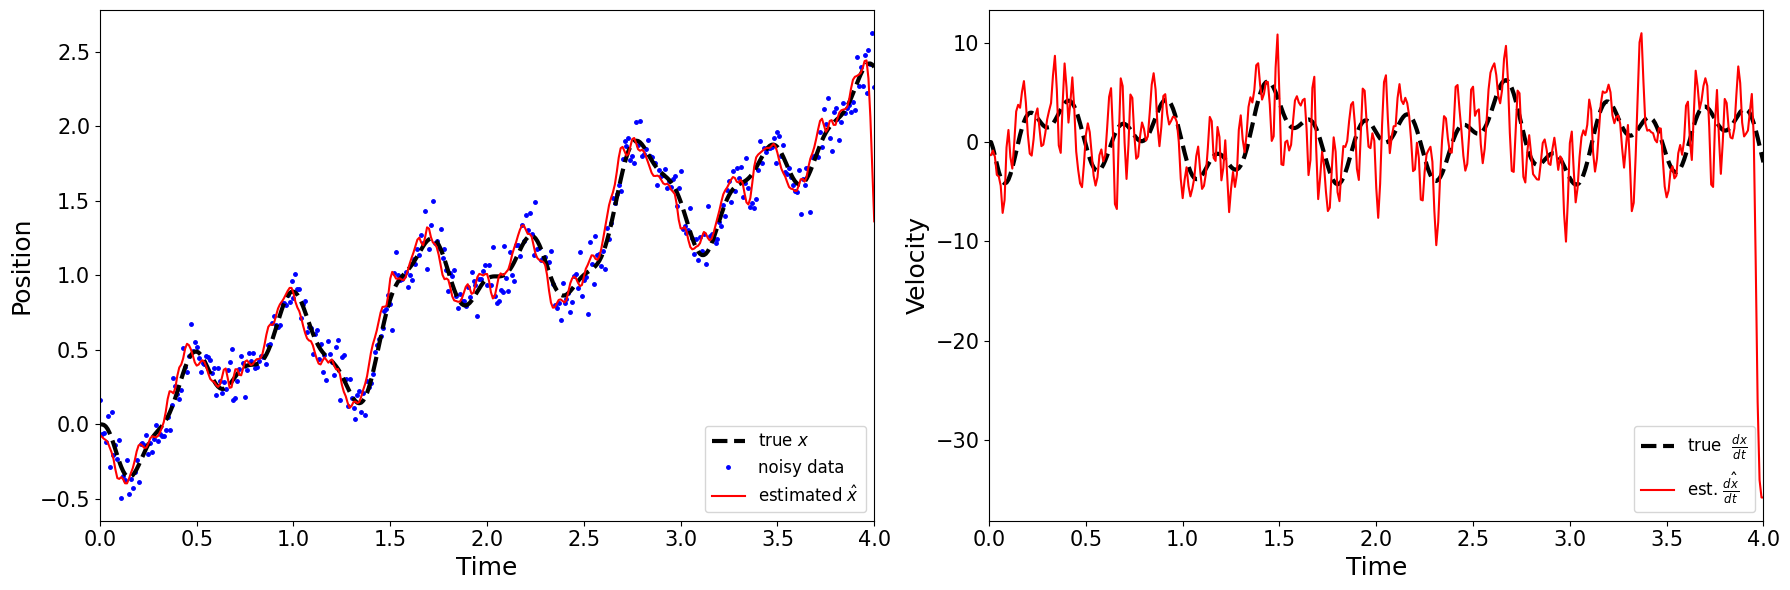

In [3]:
params, val = optimize(first_order, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = first_order(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.2 FD: Iterated Second Order

Optimal parameters:  {'num_iterations': 29}
RMS error in velocity:  0.809107525690734
Error correlation:  0.16764435000338


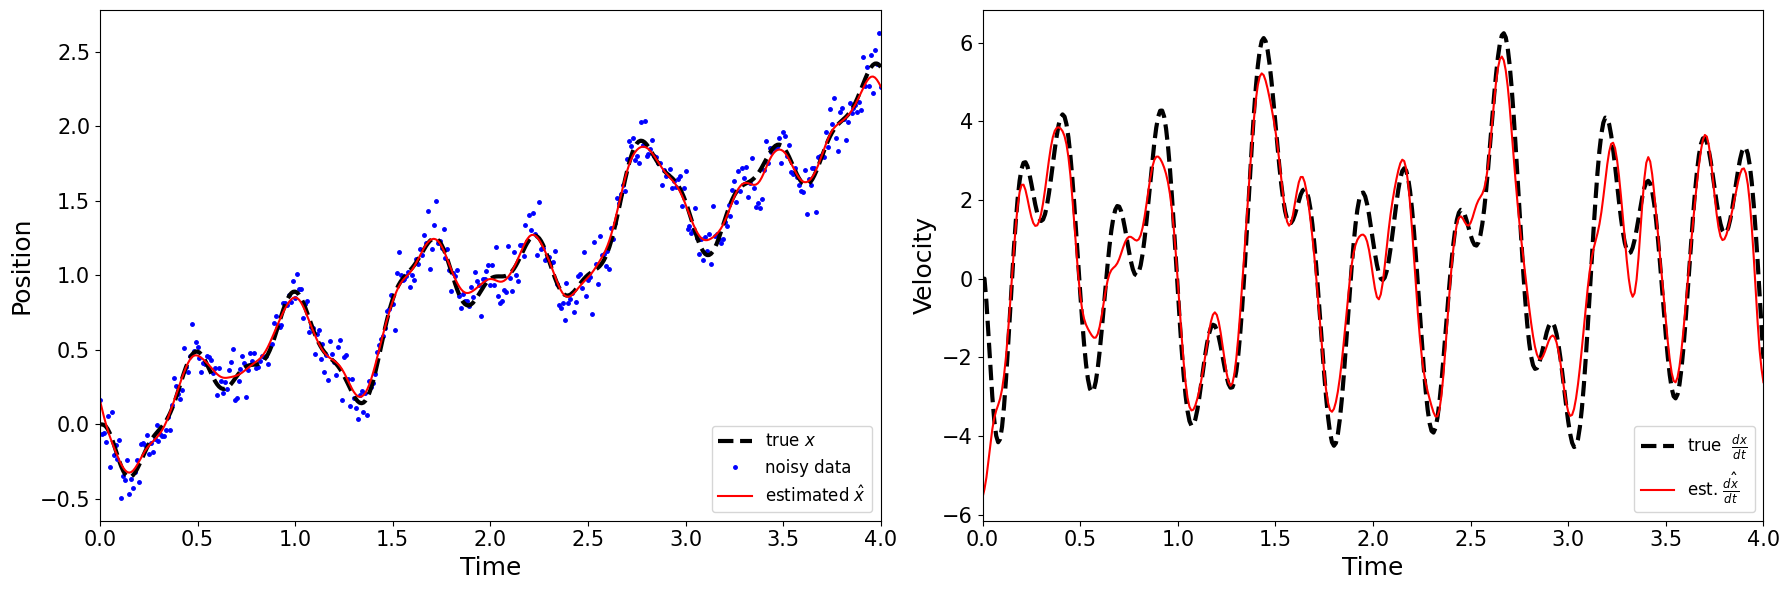

In [4]:
params, val = optimize(second_order, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = second_order(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.3 FD: Iterated Fourth Order

Optimal parameters:  {'num_iterations': 73}
RMS error in velocity:  0.6983138727849024
Error correlation:  0.19383361512213335


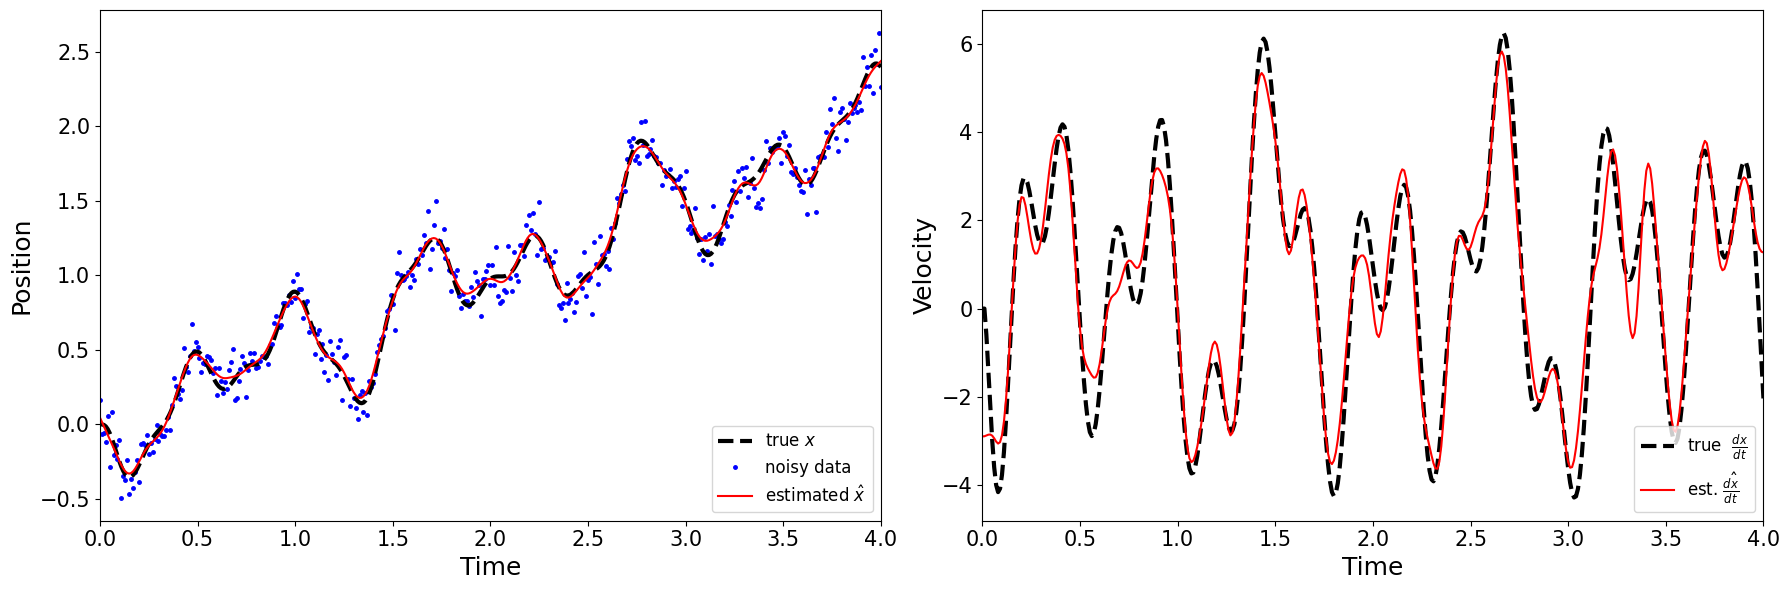

In [5]:
params, val = optimize(fourth_order, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = fourth_order(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 2. Smooth Finite Difference

### 2.1 Smooth Finite Difference: Median smoothing

Optimal parameters:  {'window_size': 15, 'num_iterations': 1}
RMS error in velocity:  1.6642127958256936
Error correlation:  0.06408324280093422


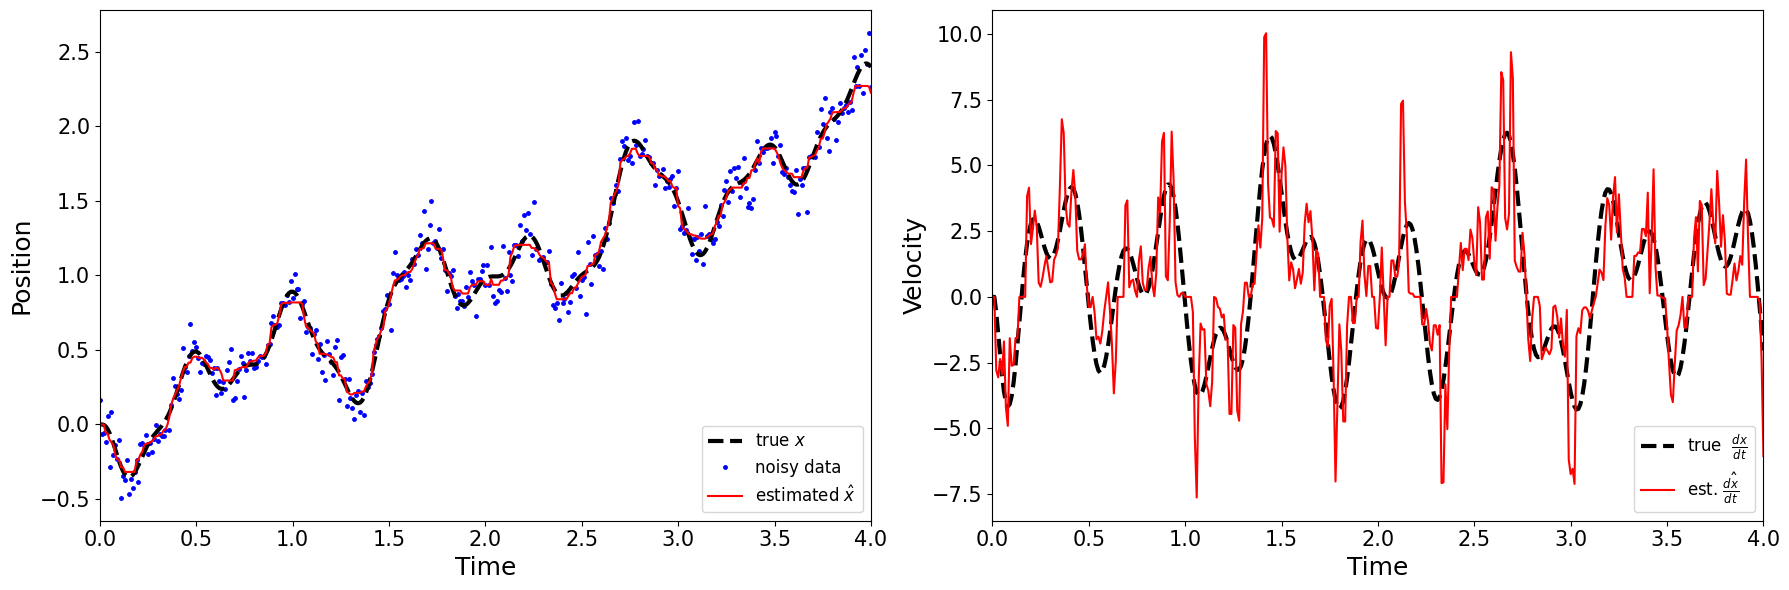

In [6]:
params, val = optimize(mediandiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = mediandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.2 Smooth Finite Difference: Mean smoothing

Optimal parameters:  {'window_size': 5, 'num_iterations': 7}
RMS error in velocity:  0.6478616199985333
Error correlation:  0.336232482542458


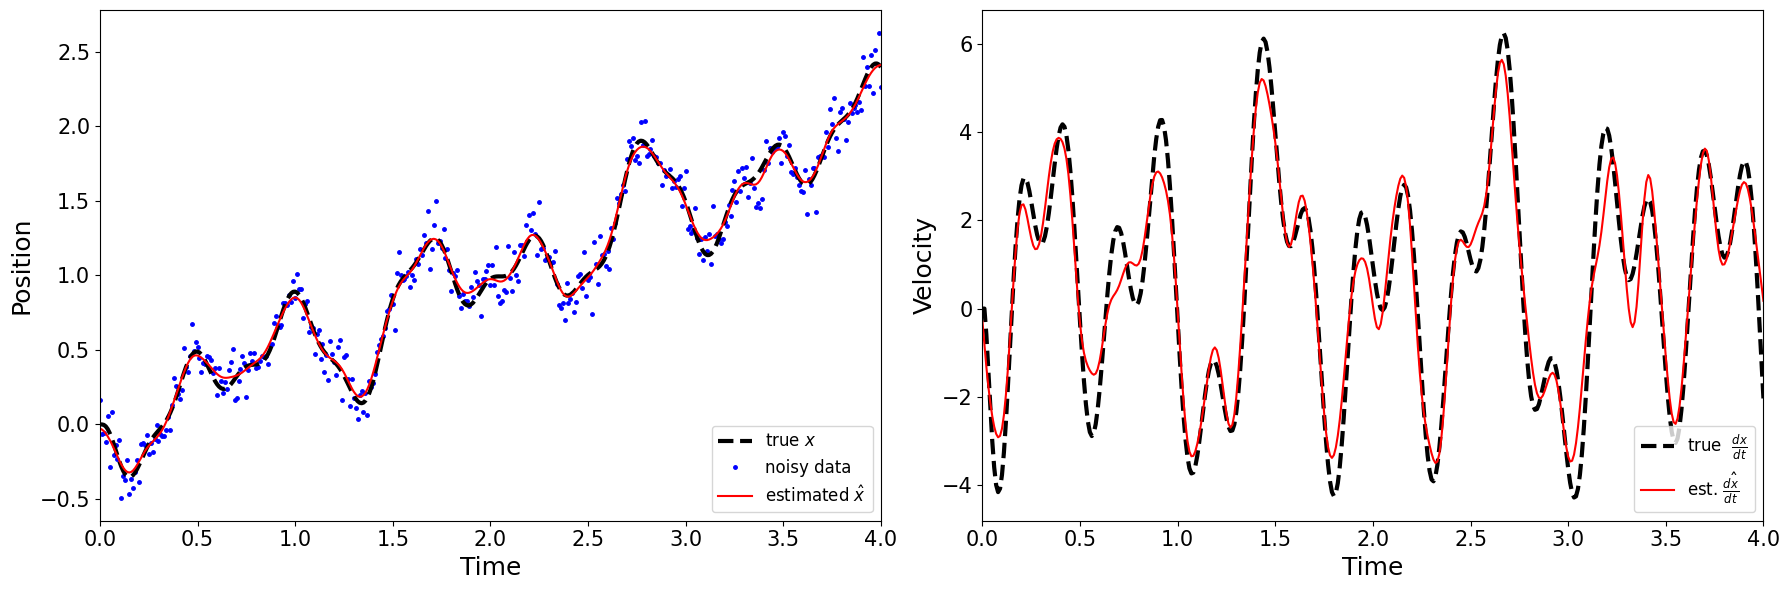

In [7]:
params, val = optimize(meandiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = meandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.3 Smooth Finite Difference: Gaussian smoothing

Optimal parameters:  {'window_size': 20, 'num_iterations': 1}
RMS error in velocity:  0.6456841747296548
Error correlation:  0.23960833068050716


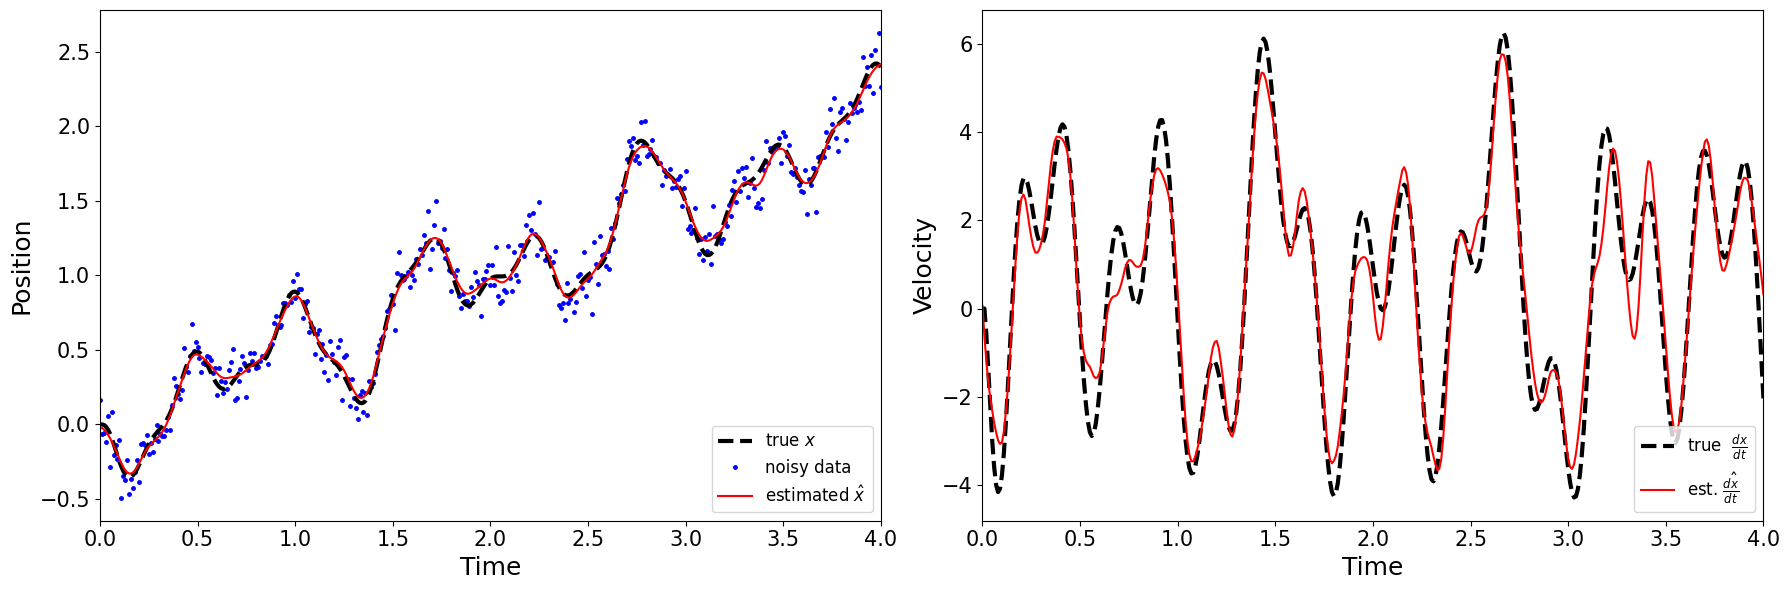

In [8]:
params, val = optimize(gaussiandiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = gaussiandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.4 Smooth Finite Difference: Friedrichs smoothing

Optimal parameters:  {'window_size': 18, 'num_iterations': 1}
RMS error in velocity:  0.648116169780203
Error correlation:  0.23535066714587305


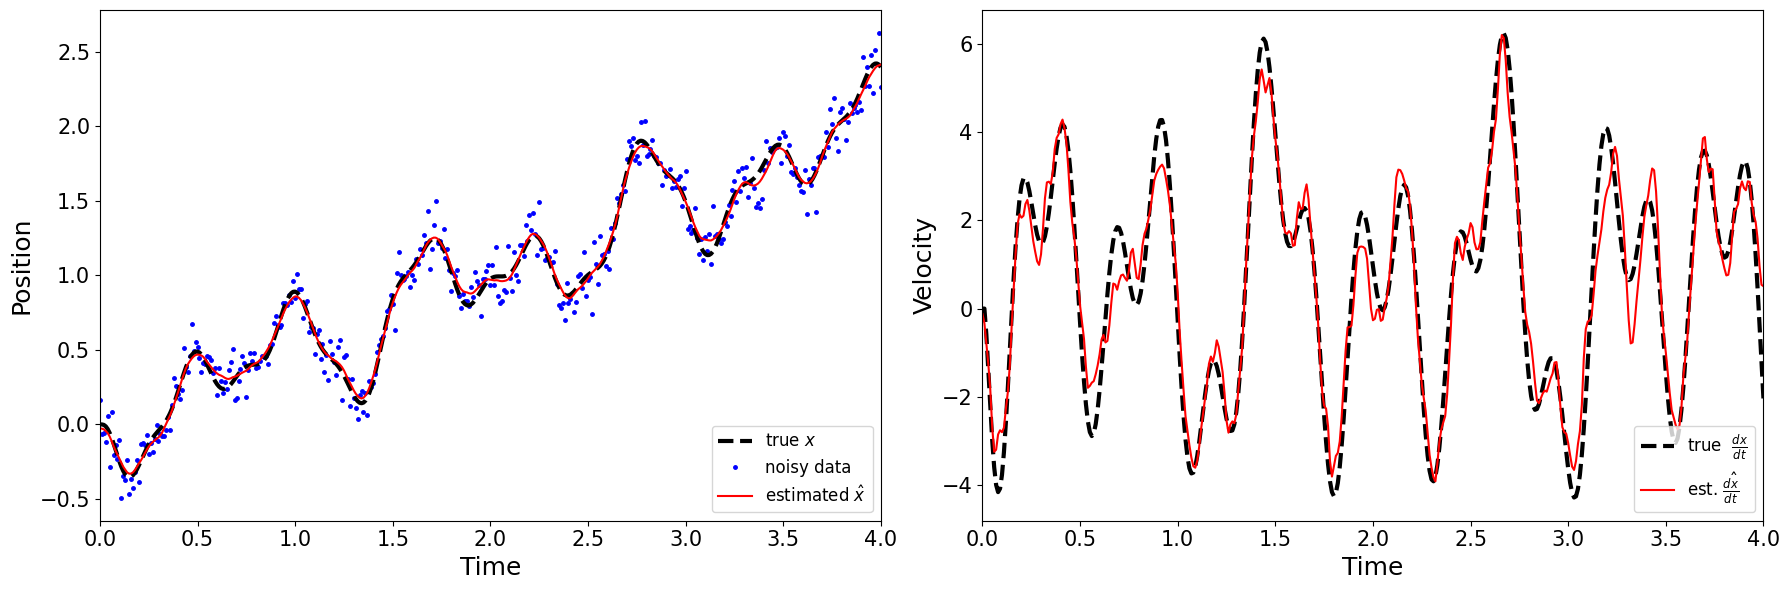

In [9]:
params, val = optimize(friedrichsdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = friedrichsdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.5 Smooth Finite Difference: Butterworth smoothing

Optimal parameters:  {'filter_order': 4, 'cutoff_freq': np.float64(0.09476176697530869), 'num_iterations': 1}
RMS error in velocity:  0.7151468176991709
Error correlation:  0.017389136753066928


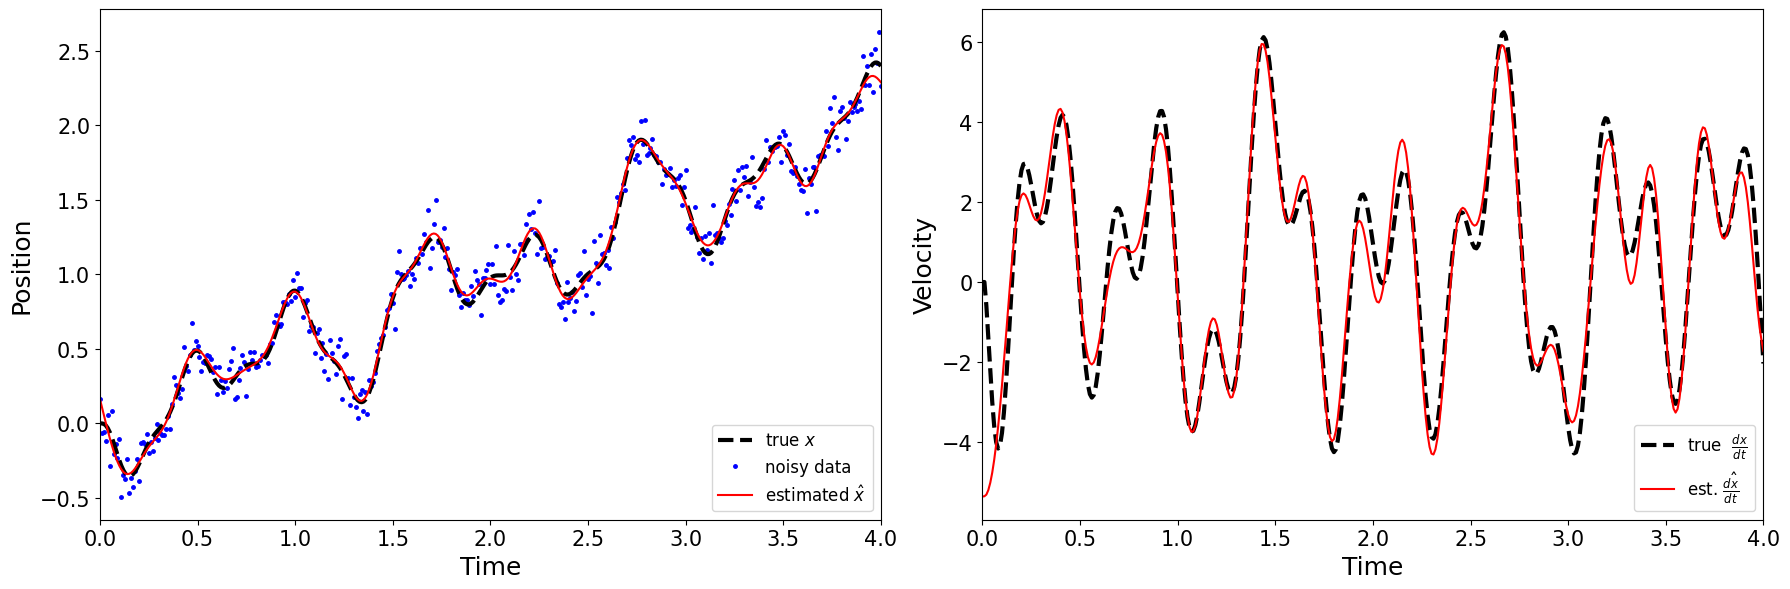

In [10]:
params, val = optimize(butterdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = butterdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.6 Smooth Finite Difference: Spline smoothing

Optimal parameters:  {'order': 3, 's': np.float64(0.5497642318244169), 'num_iterations': 5}
RMS error in velocity:  0.6016602433618093
Error correlation:  0.01739800810618806


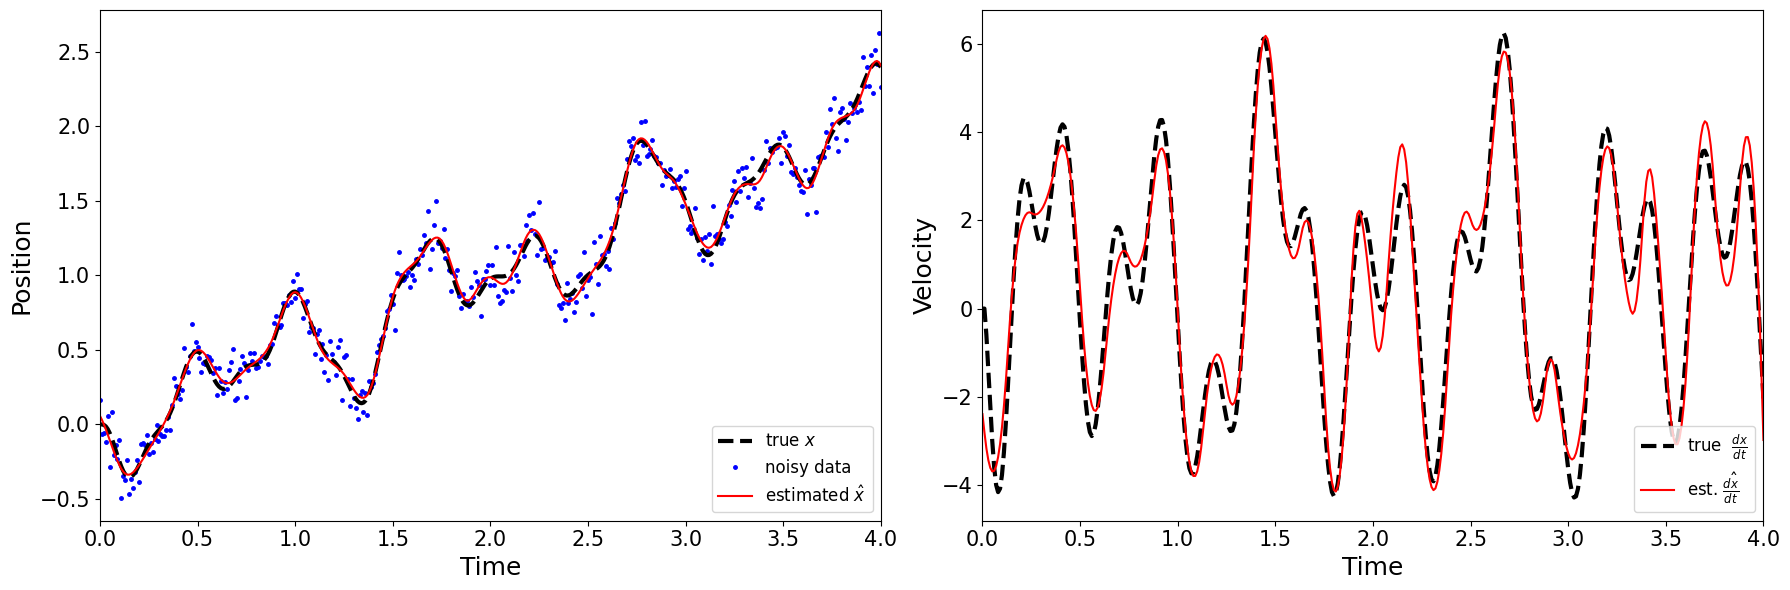

In [11]:
params, val = optimize(splinediff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = splinediff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 3. Total Variation Regularization

### 3.1 Iterative Total Variation Regularization (regularized velocity)

Optimal parameters:  {'num_iterations': 1, 'gamma': np.float64(0.001999999999999982), 'scale': 'small'}
RMS error in velocity:  0.8383254569968838
Error correlation:  0.04800940860381049


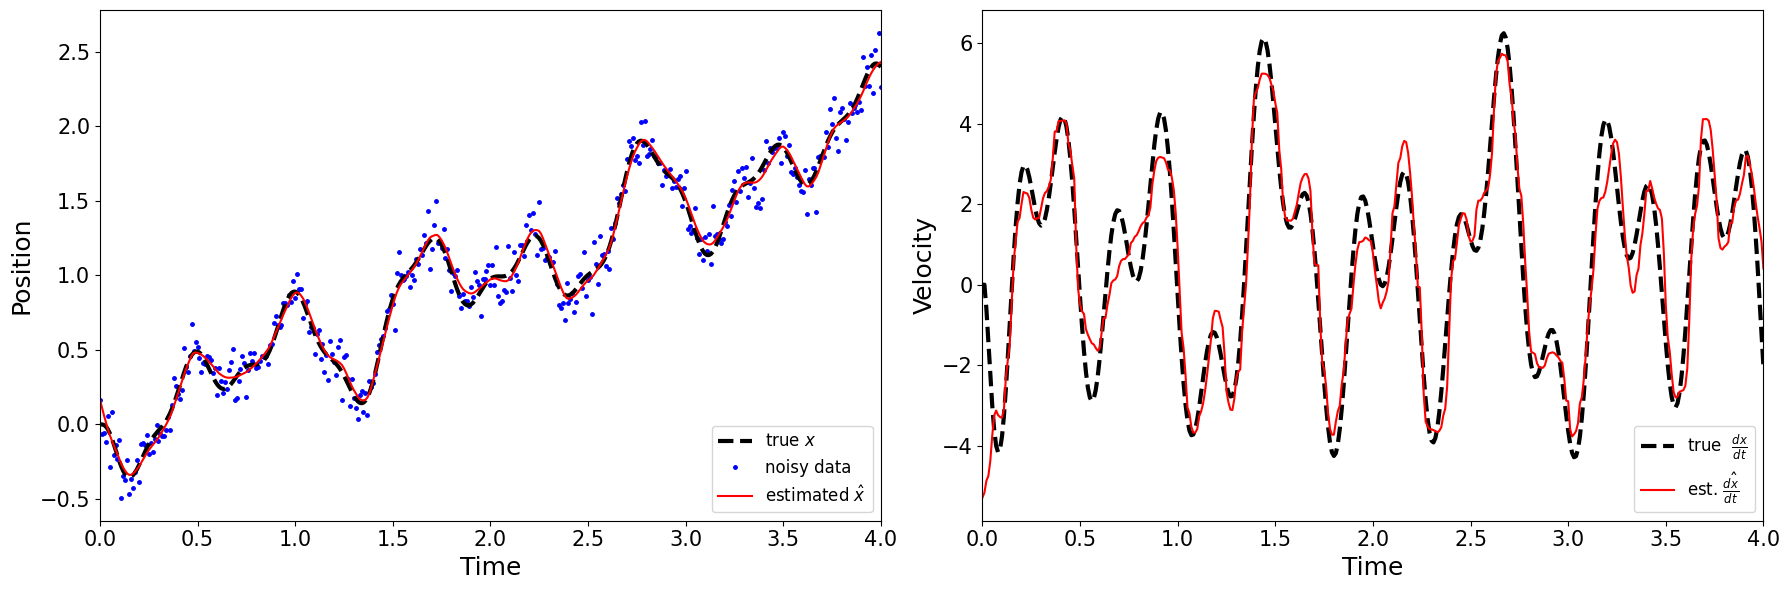

In [12]:
params, val = optimize(iterative_velocity, x, dt, search_space={'num_iterations': [1, 2, 3]}, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = iterative_velocity(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.2 Convex Total Variation Regularization: regularize velocity

Optimal parameters:  {'gamma': np.float64(2.087500000000002)}
RMS error in velocity:  0.912045980597878
Error correlation:  0.07823835437412051


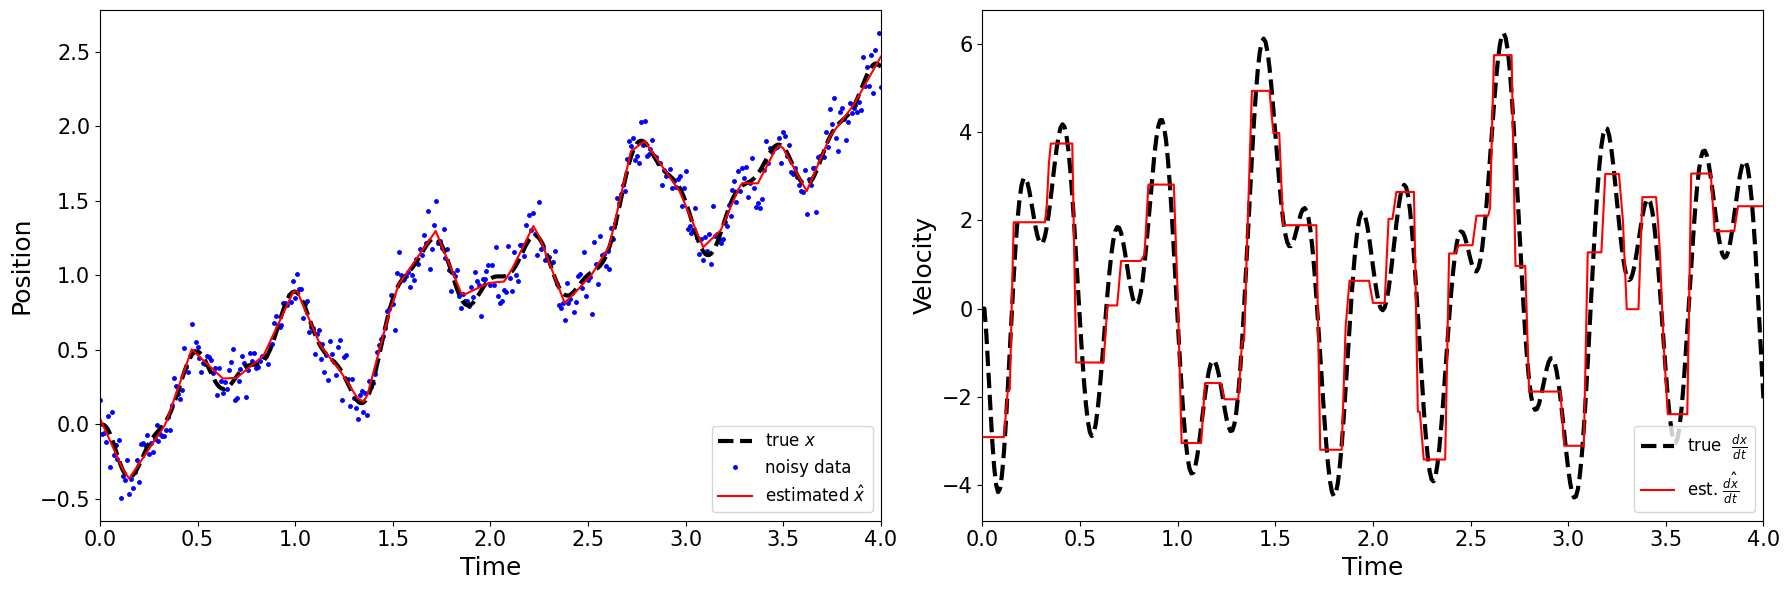

In [13]:
params, val = optimize(velocity, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = velocity(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.3 Convex Total Variation Regularization: regularize acceleration

Optimal parameters:  {'gamma': np.float64(3.0500000000000043)}
RMS error in velocity:  0.7768695179626233
Error correlation:  0.007909499960311176


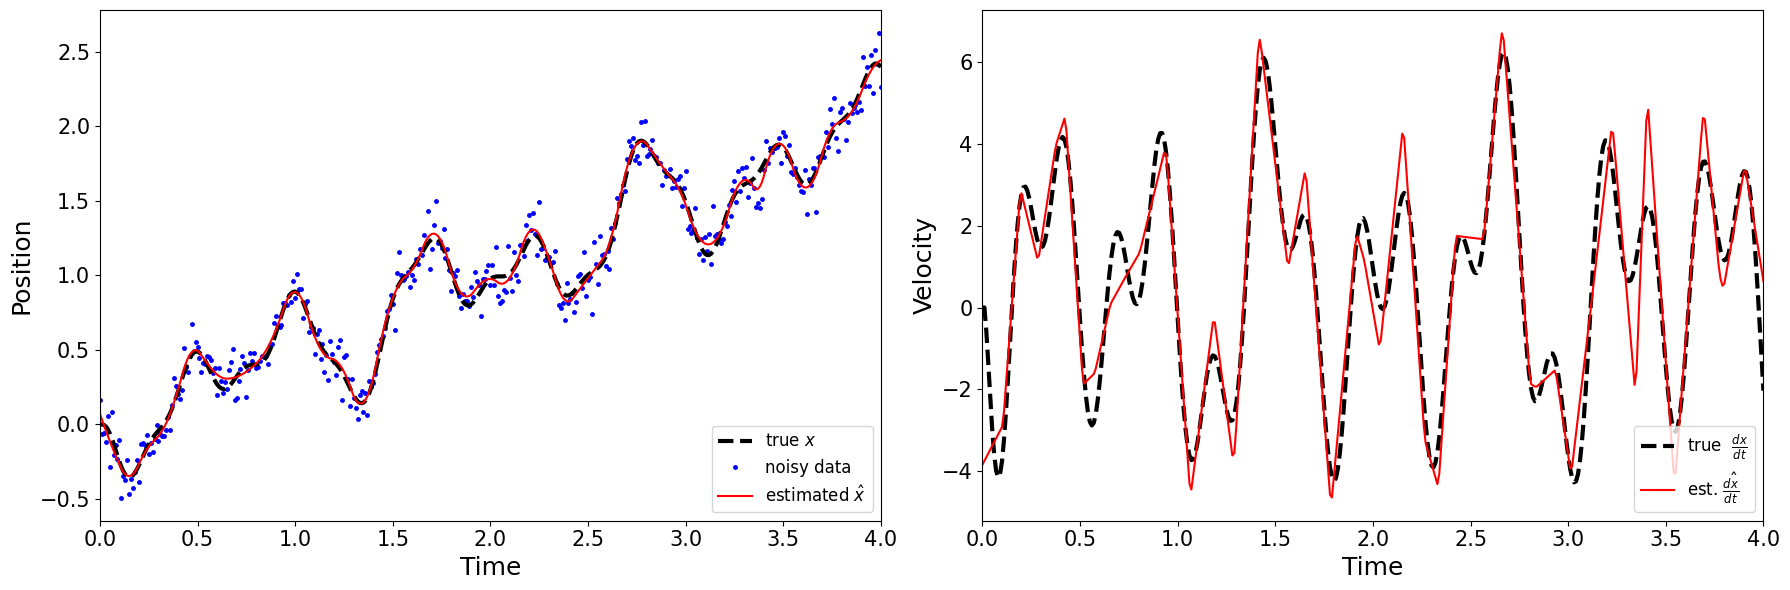

In [14]:
params, val = optimize(acceleration, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.4 Convex Total Variation Regularization: regularize jerk

Optimal parameters:  {'gamma': np.float64(12.150000000000023)}
RMS error in velocity:  0.6192338213354801
Error correlation:  0.008727874377168711


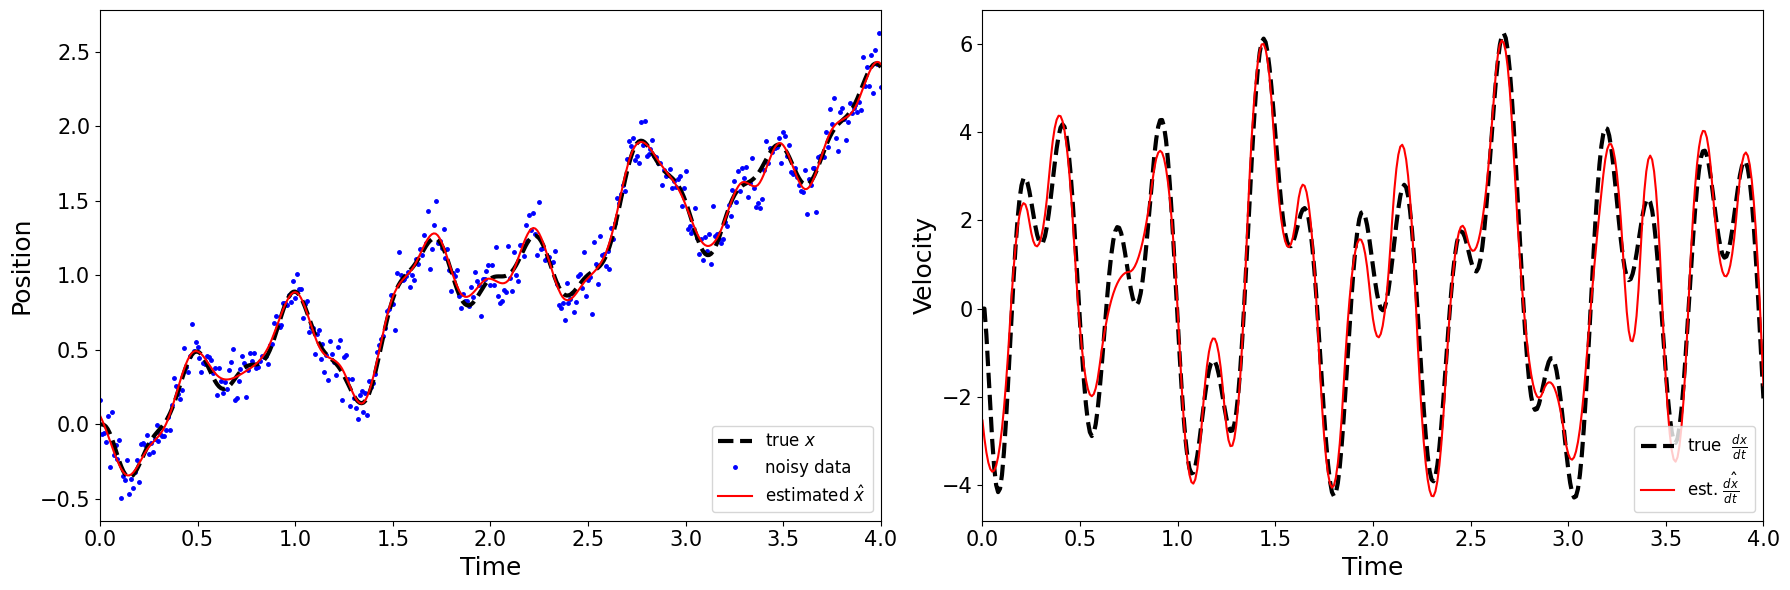

In [15]:
params, val = optimize(jerk, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = jerk(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.5 Convex Total Variation Regularization: regularize acceleration with gaussian smoothing

Optimal parameters:  {'gamma': np.float64(1.2152343749999992), 'window_size': 16}
RMS error in velocity:  0.6504385722720329
Error correlation:  0.10004858949921591


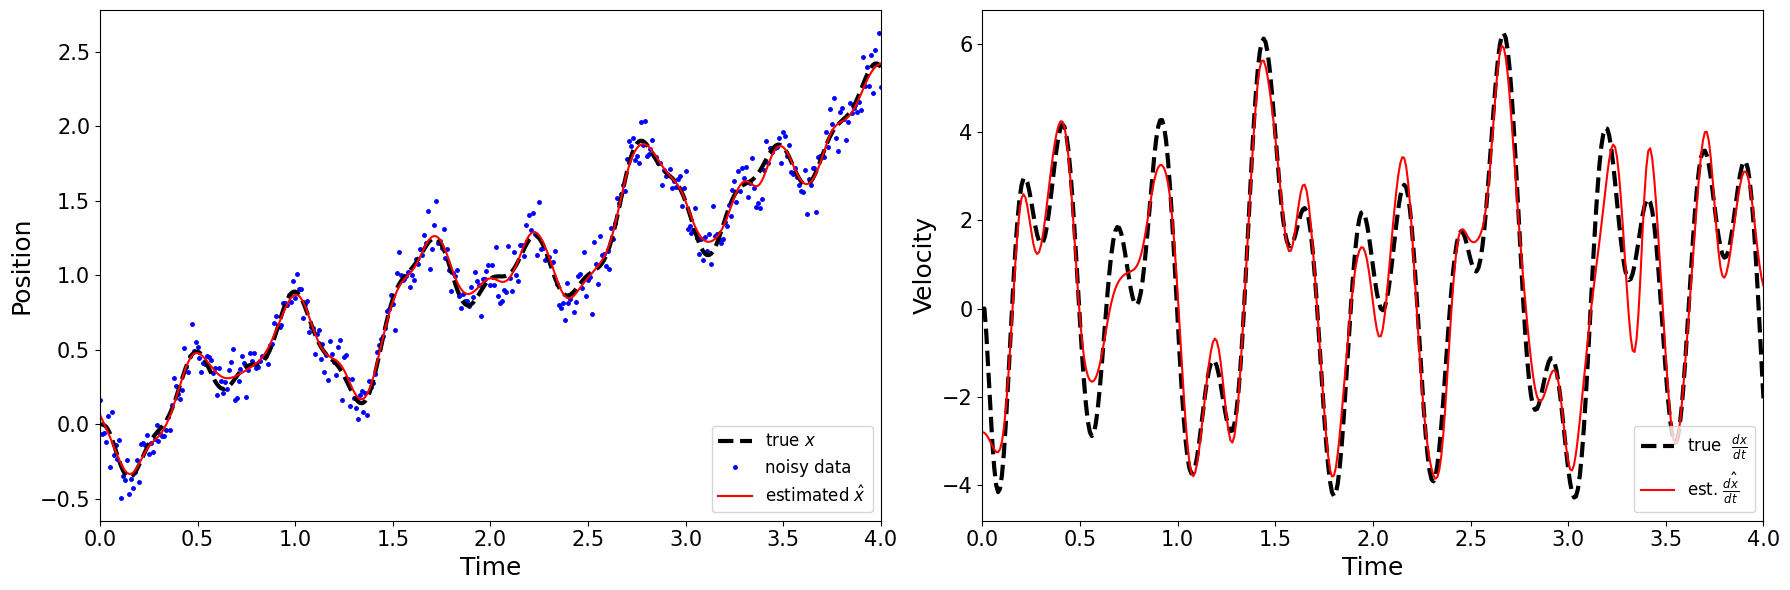

In [16]:
params, val = optimize(smooth_acceleration, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = smooth_acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 4. Linear Models

### 4.1 Linear Models: Spectral derivative

Optimal parameters:  {'even_extension': np.True_, 'pad_to_zero_dxdt': np.True_, 'high_freq_cutoff': np.float64(0.10956790123456793)}
RMS error in velocity:  0.6730424283473954
Error correlation:  0.020043504104904988


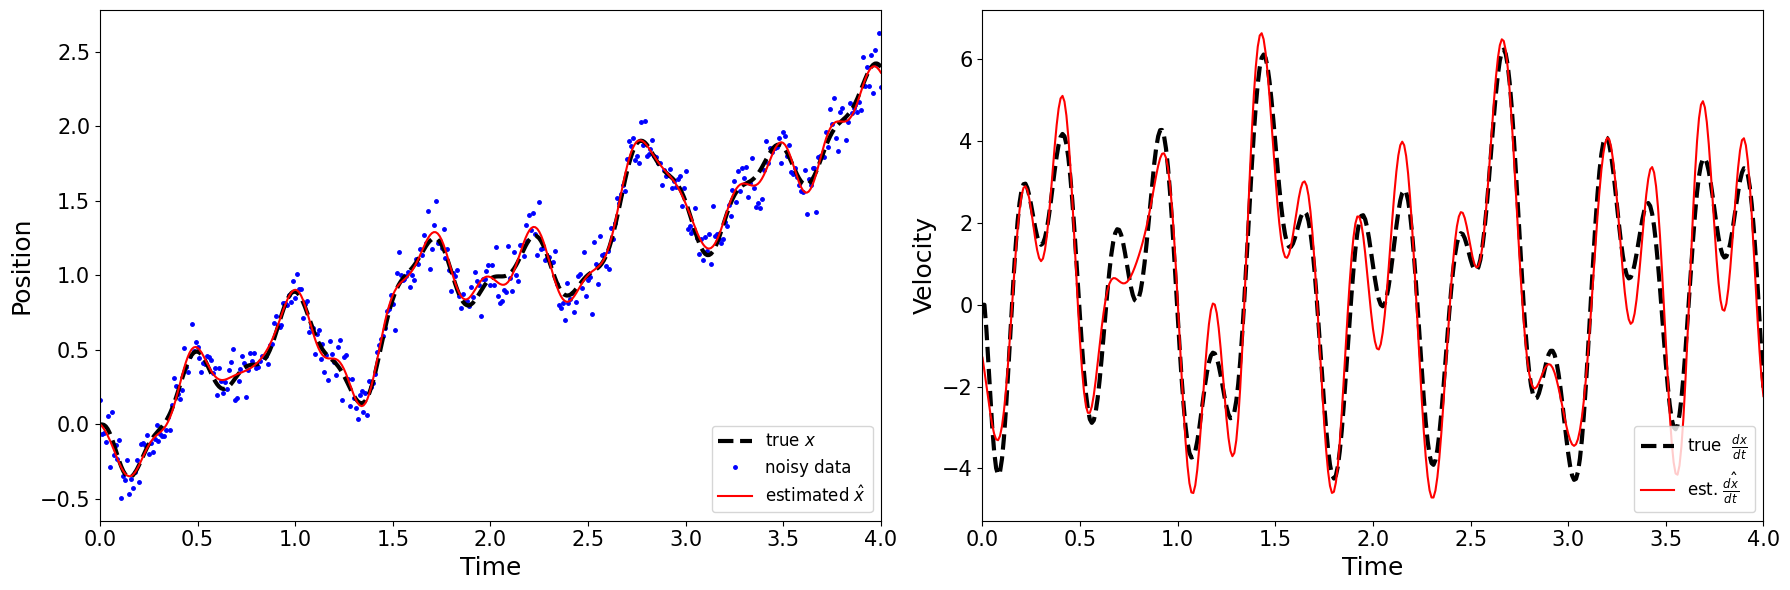

In [17]:
params, val = optimize(spectraldiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = spectraldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.2 Linear Models: Sliding polynomial fit

Optimal parameters:  {'step_size': 1, 'poly_order': 3, 'window_size': 40, 'kernel': 'friedrichs'}


/Users/pavel/Code/PyNumDiff/pynumdiff/linear_model/_linear_model.py:95: UserWarning: Kernel window size should be odd. Added 1 to length.
  warn("Kernel window size should be odd. Added 1 to length.")


RMS error in velocity:  0.5727285849814204
Error correlation:  2.2687822224677363e-05


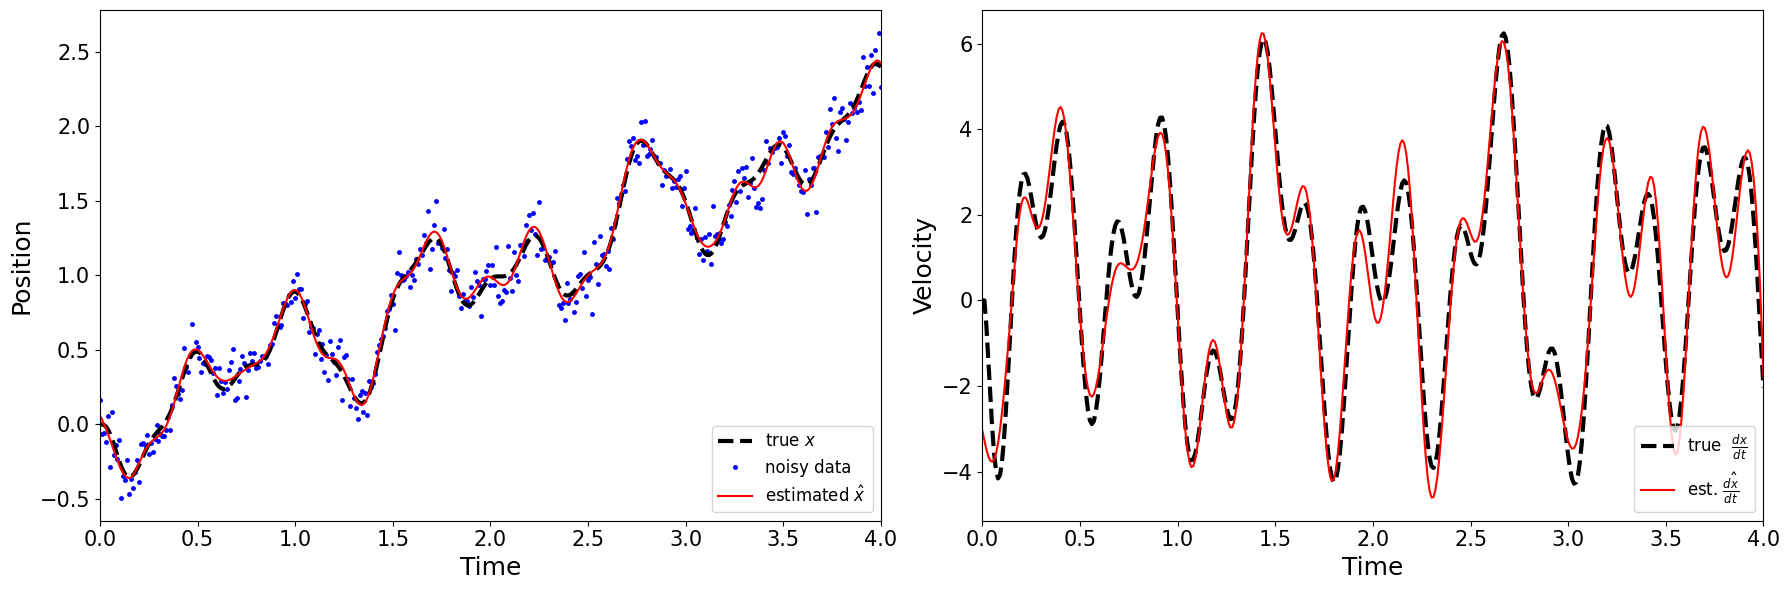

In [18]:
params, val = optimize(polydiff, x, dt, search_space={'step_size':[1, 2, 5]}, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = polydiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.3 Linear Models: Savitzky-Golay filter

Optimal parameters:  {'poly_order': 5, 'window_size': 39, 'smoothing_win': 12}
RMS error in velocity:  0.5148645883411752
Error correlation:  0.06099842962669914


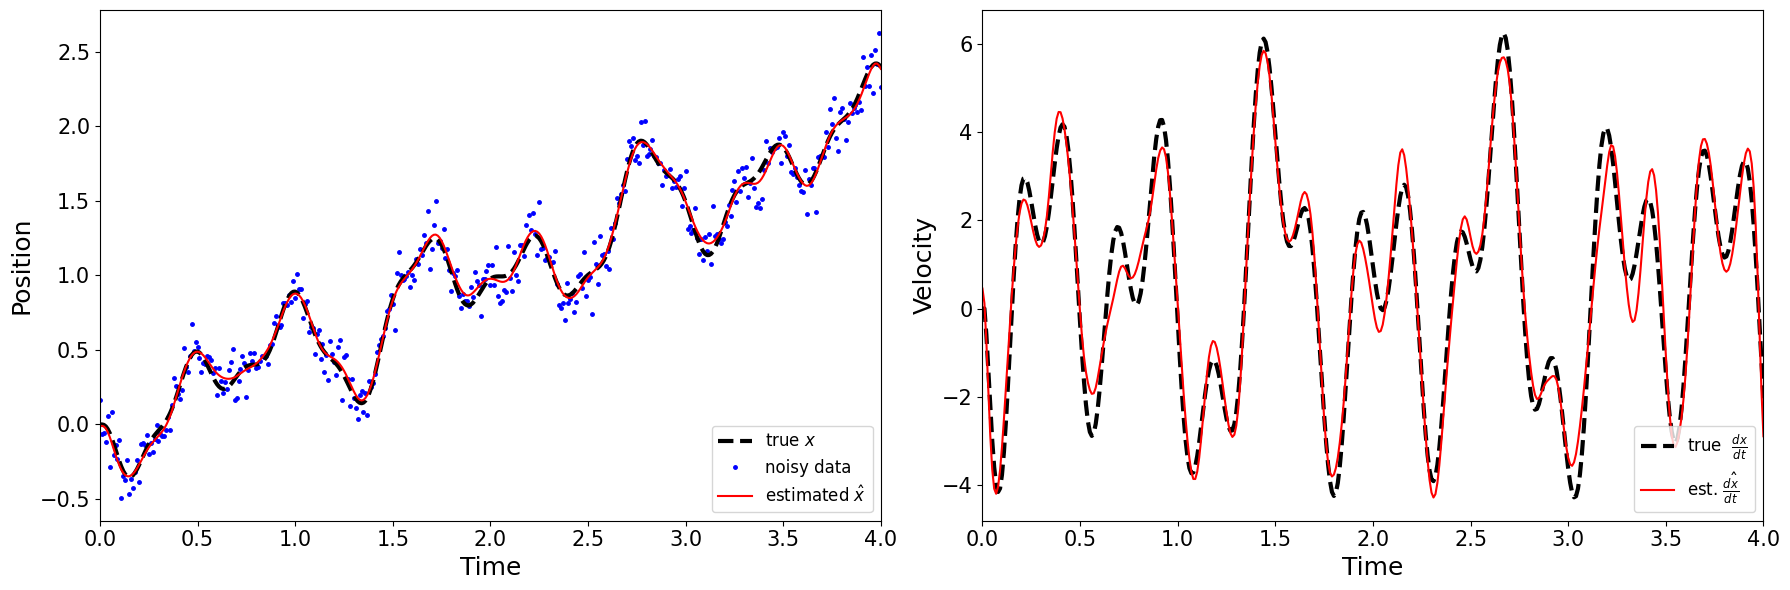

In [19]:
params, val = optimize(savgoldiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = savgoldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.5 Linear Models: Sliding linear time invariant system fit

In [20]:
if 0: # this one is too slow and runtime error prone!
    params, val = optimize(lineardiff, x, dt, dxdt_truth=dxdt_truth)
    print('Optimal parameters: ', params)
    x_hat, dxdt_hat = lineardiff(x, dt, **params)
    evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## Kalman smoothing

### 5.1 Kalman smoothing: constant velocity

Optimal parameters:  {'forwardbackward': np.True_, 'q': np.float64(10.555555555555554), 'r': np.float64(0.09666666666666668)}
RMS error in velocity:  0.6716938599254324
Error correlation:  0.07220467244105934


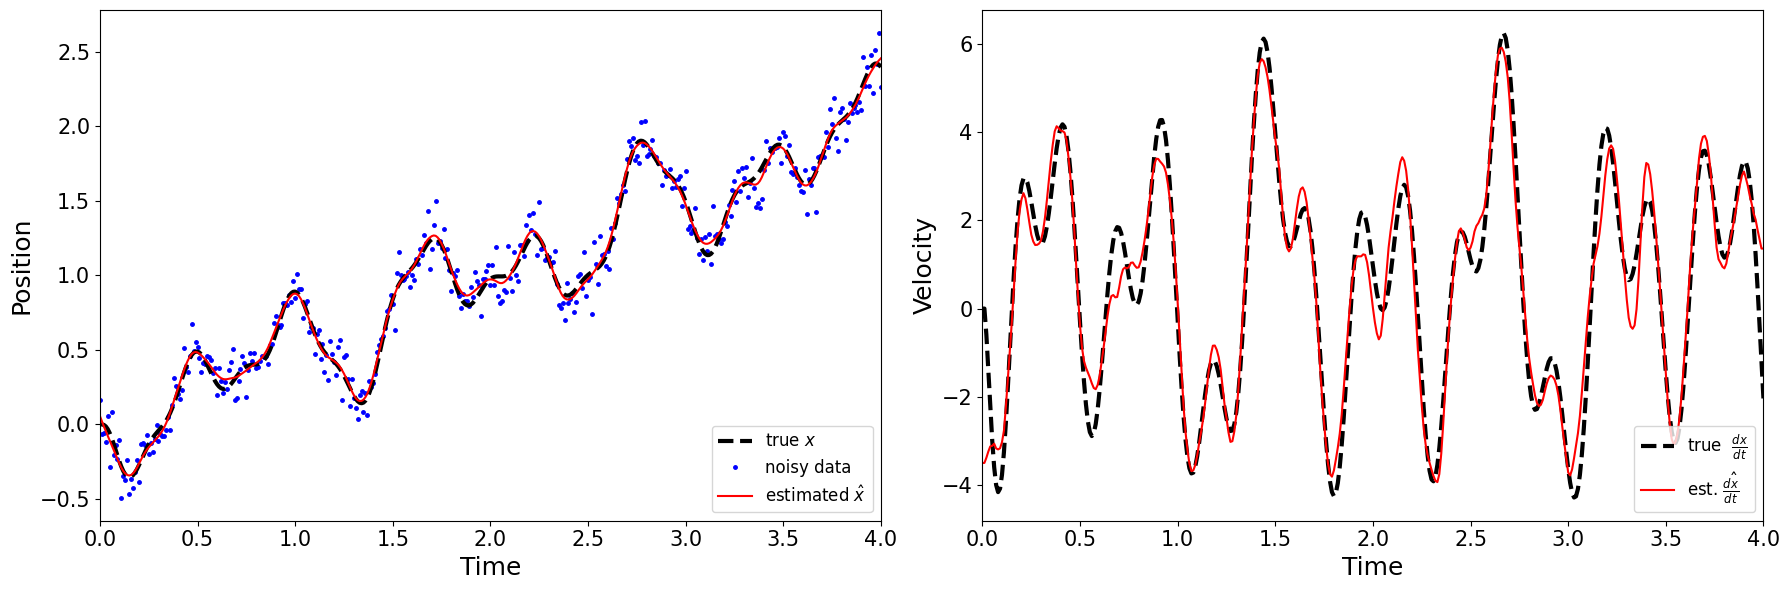

In [21]:
params, val = optimize(constant_velocity, x, dt, search_space={'forwardbackward': [True, False]}, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = constant_velocity(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.2 Kalman smoothing: constant acceleration

Optimal parameters:  {'forwardbackward': np.False_, 'q': np.float64(151666666.66666645), 'r': np.float64(2333.333333333314)}
RMS error in velocity:  0.5417224554391387
Error correlation:  0.05099420450057886


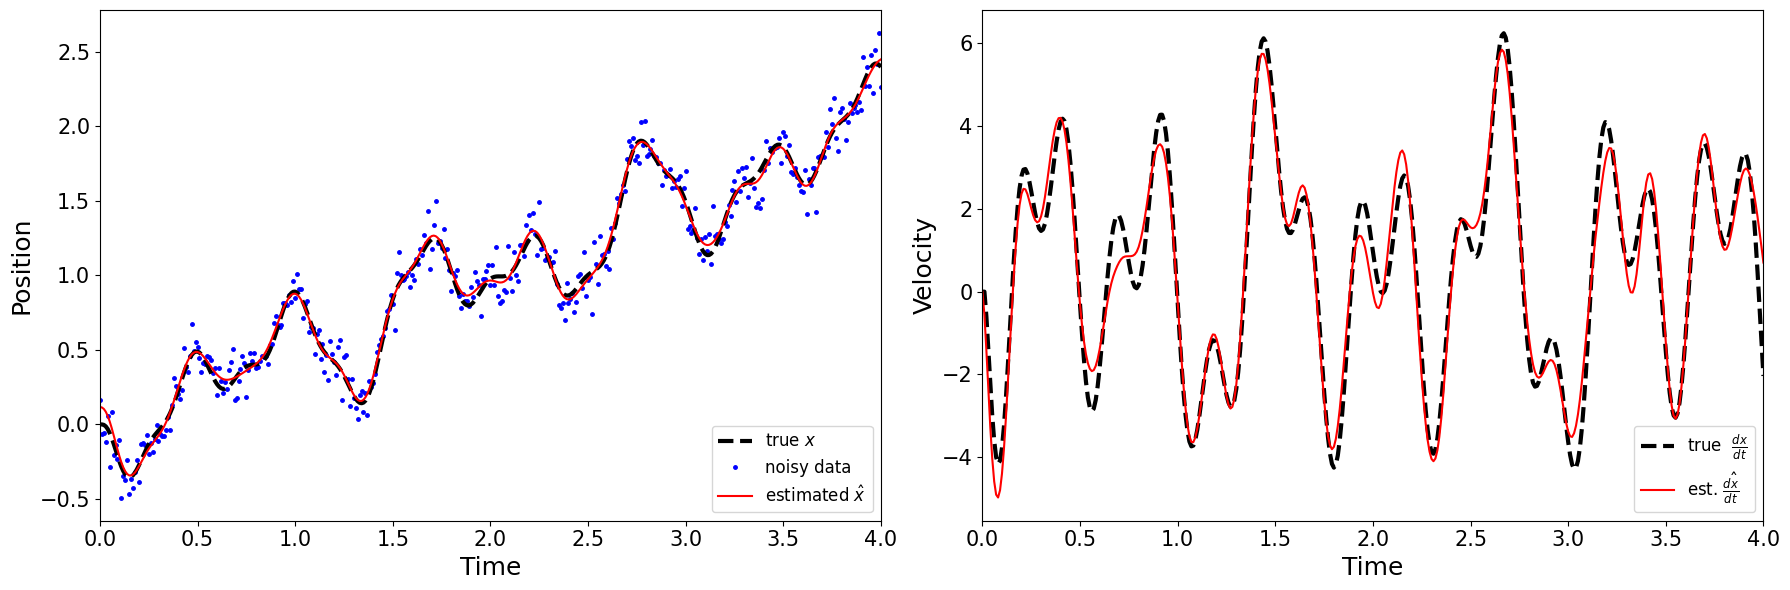

In [22]:
params, val = optimize(constant_acceleration, x, dt, search_space={'forwardbackward': [True, False]}, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = constant_acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.3 Kalman smoothing: constant jerk

Optimal parameters:  {'forwardbackward': np.False_, 'q': np.float64(151666666.66666645), 'r': np.float64(2.3333333333333464)}
RMS error in velocity:  0.48984124660364586
Error correlation:  0.049211828479164055


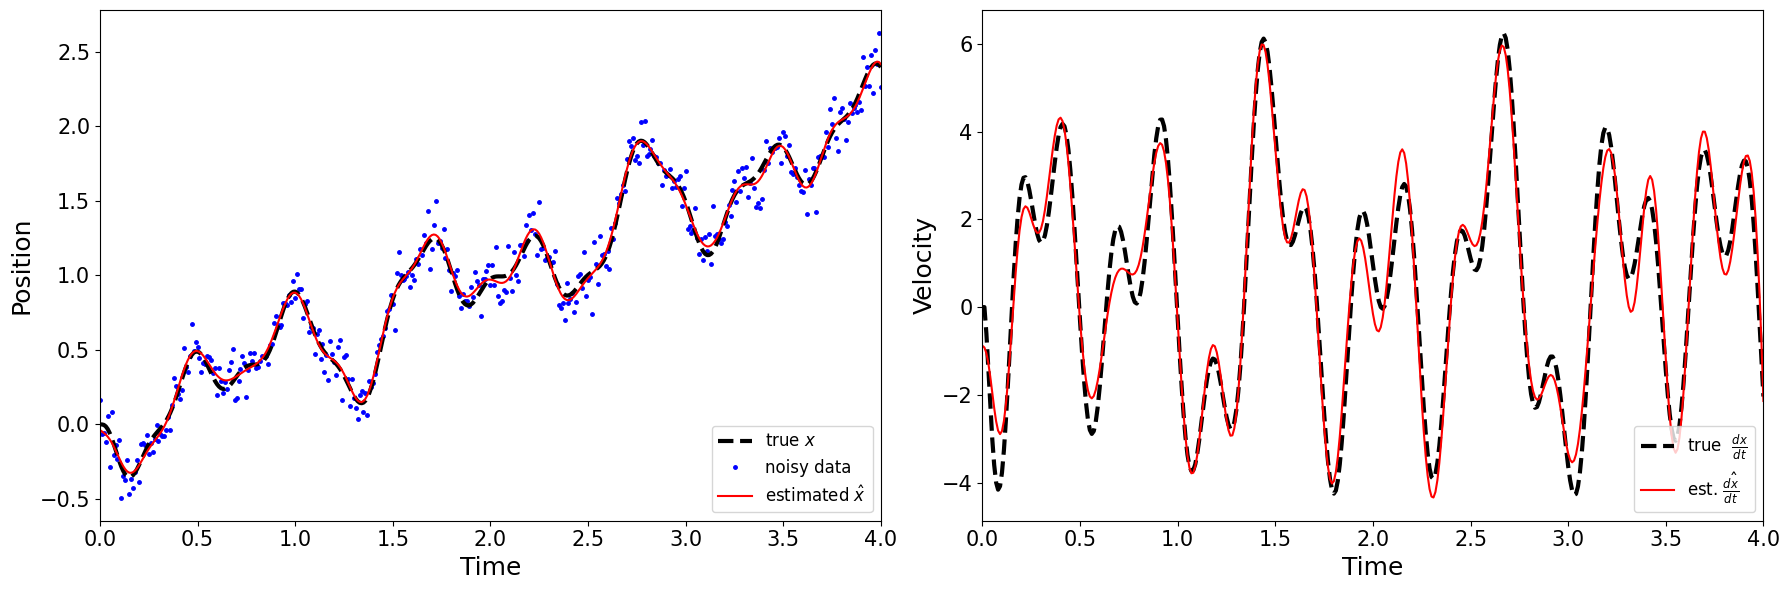

In [23]:
params, val = optimize(constant_jerk, x, dt, search_space={'forwardbackward': [True, False]}, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = constant_jerk(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)